In [1]:
import pandas as pd
import numpy as np
import pickle
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt
import os
import sys


from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
print(BASE_DIR)
import scripts.functions as fn


c:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www\backtest
C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [2]:
timeframe = '2d01'

klines_file = f'./backtest/klines/{timeframe}/Completo_BTCUSDT_{timeframe}_2021-01-01_2023-07-31.DataFrame'
with open(klines_file, 'rb') as file:
    btc = pickle.load(file)

klines_file = f'./backtest/klines/{timeframe}/Completo_BNBUSDT_{timeframe}_2021-01-01_2023-07-31.DataFrame'
with open(klines_file, 'rb') as file:
    bnb = pickle.load(file)

klines_file = f'./backtest/klines/{timeframe}/Completo_ETHUSDT_{timeframe}_2021-01-01_2023-07-31.DataFrame'
with open(klines_file, 'rb') as file:
    eth = pickle.load(file)
    
start_date = klines_file.split('/')[4].split('_')[3] #Extrae la fecha de inicio
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
start_date = start_date.replace(hour=0, minute=0, second=0)

df = btc.copy()
df['btc'] = df['close']
df.drop('high', axis=1, inplace=True)
df.drop('low', axis=1, inplace=True)
df.drop('open', axis=1, inplace=True)
df.drop('close', axis=1, inplace=True)
df.drop('volume', axis=1, inplace=True)

df['eth'] = eth['close']
df['bnb'] = bnb['close']


"""
periodo original: '2021-01-01' al '2023-07-31'

"""

start_date = pd.to_datetime('2021-06-01', format='%Y-%m-%d')
end_date   = pd.to_datetime('2023-07-31', format='%Y-%m-%d')
start_date = start_date.replace(hour=0, minute=0, second=0)
end_date   = end_date.replace(hour=0, minute=0, second=0)

df = df[df['datetime']>=start_date]
df = df[df['datetime']<=end_date]
df.reset_index(inplace = True)
df.set_index('datetime',inplace=True)
df.drop('index', axis=1, inplace=True)

df.rename(columns={'btc': 'btc_price', 'eth': 'eth_price', 'bnb': 'bnb_price'}, inplace=True)

In [3]:
usd_per_asset = 500.0
usd_diff = 12.0
df['usdt_qty'] = usd_per_asset
df['btc_qty'] = usd_per_asset/df.iloc[0]['btc_price']
df['eth_qty'] = usd_per_asset/df.iloc[0]['eth_price']
df['bnb_qty'] = usd_per_asset/df.iloc[0]['bnb_price']
df['hold'] = round(df['usdt_qty'] + df['btc_qty'] * df['btc_price'] + df['eth_qty'] * df['eth_price'] + df['bnb_qty'] * df['bnb_price'] ,2)


wallet = pd.Series(dtype=float)
srs_usd = pd.Series()
srs_btc = pd.Series()
srs_eth = pd.Series()
srs_bnb = pd.Series()

i=0
for row in df.itertuples(index=True, name='OHLCV'):
    if i == 0:
        usdt_qty = row.usdt_qty
        btc_qty = row.btc_qty
        eth_qty = row.eth_qty
        bnb_qty = row.bnb_qty
    else:
        btc_usd = btc_qty * row.btc_price
        eth_usd = eth_qty * row.eth_price
        bnb_usd = bnb_qty * row.bnb_price
        
        if btc_usd > usd_per_asset + usd_diff:
            usd = btc_usd - usd_per_asset
            qty = usd/row.btc_price
            usdt_qty += usd
            btc_qty  -= qty
        elif btc_usd < usd_per_asset - usd_diff:
            usd = usd_per_asset - btc_usd
            if usdt_qty >= usd:
                qty = usd/row.btc_price
                usdt_qty -= usd
                btc_qty  += qty

        if eth_usd > usd_per_asset + usd_diff:
            usd = eth_usd - usd_per_asset
            qty = usd/row.eth_price
            usdt_qty += usd
            eth_qty  -= qty
        elif eth_usd < usd_per_asset - usd_diff:
            usd = usd_per_asset - eth_usd
            if usdt_qty >= usd:
                qty = usd/row.eth_price
                usdt_qty -= usd
                eth_qty  += qty
        
        if bnb_usd > usd_per_asset + usd_diff:
            usd = bnb_usd - usd_per_asset
            qty = usd/row.bnb_price
            usdt_qty += usd
            bnb_qty  -= qty
        elif bnb_usd < usd_per_asset - usd_diff:
            usd = usd_per_asset - bnb_usd
            if usdt_qty >= usd:
                qty = usd/row.bnb_price
                usdt_qty -= usd
                bnb_qty  += qty

        

    wallet[row.Index] = round(usdt_qty + btc_qty*row.btc_price + eth_qty*row.eth_price + bnb_qty*row.bnb_price ,2)
    srs_usd[row.Index] = round(usdt_qty ,2)
    srs_btc[row.Index] = btc_qty * row.btc_price
    srs_eth[row.Index] = eth_qty * row.eth_price
    srs_bnb[row.Index] = bnb_qty * row.bnb_price
    i += 1
    
df['wallet'] = wallet
df['usd_usd'] = srs_usd
df['btc_usd'] = srs_btc
df['eth_usd'] = srs_eth
df['bnb_usd'] = srs_bnb

Renta: 15.87 USD Inicial: 2000.00 USD Final: 2317.47
Hold: -20.84  USD Inicial: 2000.00 USD Final: 1583.12


<Axes: xlabel='datetime'>

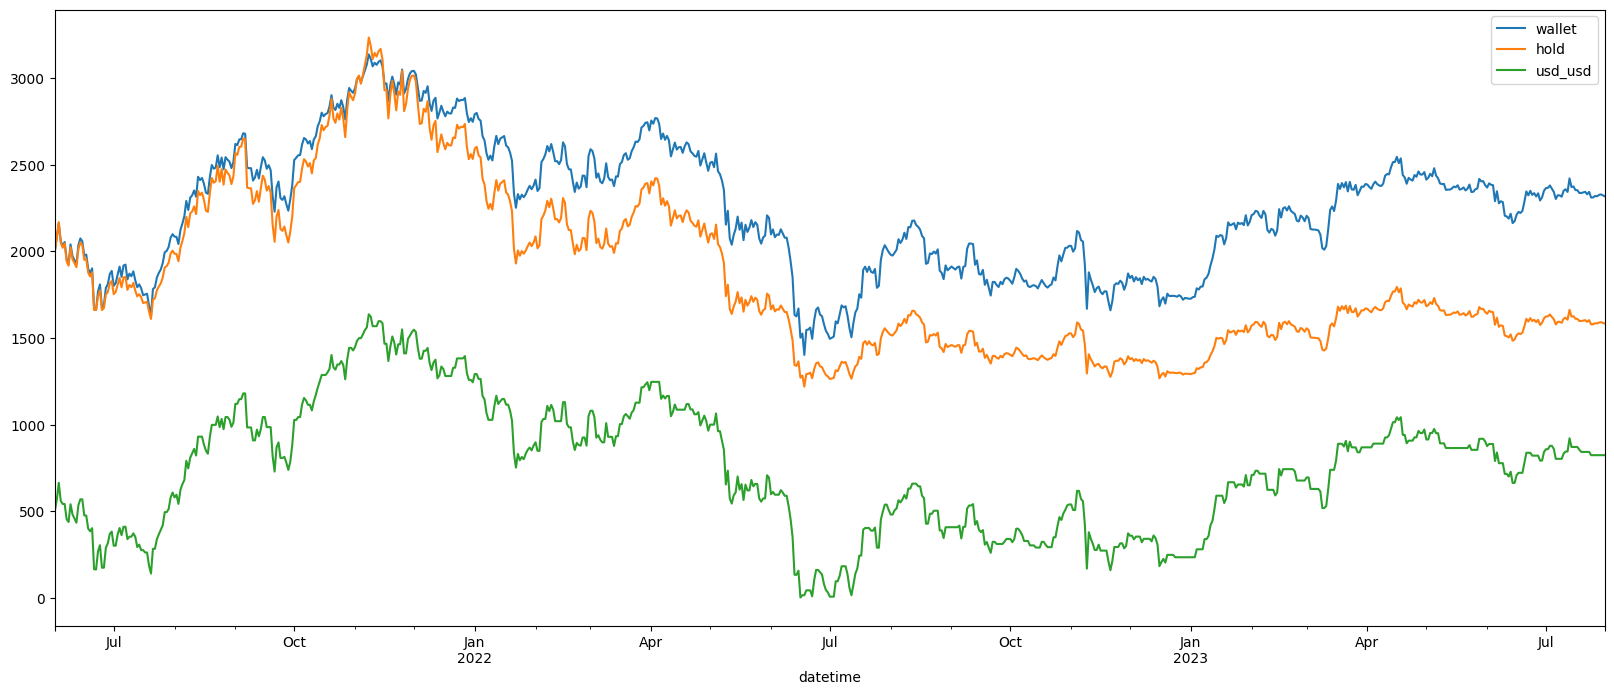

In [4]:
fin = df.iloc[-1]['wallet']
inicio = df.iloc[0]['wallet']
renta = ((fin/inicio)-1)*100
print(f'Renta: {renta:.2f} USD Inicial: {inicio:.2f} USD Final: {fin:.2f}')

fin = df.iloc[-1]['hold']
inicio = df.iloc[0]['hold']
hold = ((fin/inicio)-1)*100
print(f'Hold: {hold:.2f}  USD Inicial: {inicio:.2f} USD Final: {fin:.2f}')

df[['wallet','hold','usd_usd']].plot(figsize = (20,8))

